In [109]:
import warnings

# 禁用所有警告
warnings.filterwarnings("ignore")

## 載入要用的資料集

##### Open: 開盤價
##### High: 最高價
##### Low: 最低價
##### Close: 收盤價
##### Adj Close: 調整後收盤價（考慮股息和分拆影響）
##### Volume: 交易量

In [113]:
import datetime
import yfinance as yf

stock_number = '0050.TW'
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2024, 1, 16)

df = yf.download(stock_number, start=start, end=end)
print(df.info())
print(df.head(-5))
print(df.isnull().sum())

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3942 entries, 2008-01-02 00:00:00+00:00 to 2024-01-15 00:00:00+00:00
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Adj Close, 0050.TW)  3942 non-null   float64
 1   (Close, 0050.TW)      3942 non-null   float64
 2   (High, 0050.TW)       3942 non-null   float64
 3   (Low, 0050.TW)        3942 non-null   float64
 4   (Open, 0050.TW)       3942 non-null   float64
 5   (Volume, 0050.TW)     3942 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 215.6 KB
None
Price                       Adj Close       Close        High         Low  \
Ticker                        0050.TW     0050.TW     0050.TW     0050.TW   
Date                                                                        
2008-01-02 00:00:00+00:00   42.407543   60.009998   60.009998   60.009998   
2008-01-03 00:00:00+00:00   41.616062   58.889999   58.889999   58.889999

## 定義資料預處理的function

In [116]:
import numpy as np

def Stock_Price_LSTM_Data_Preprocessing(df, mem_his_days, pre_days):
    df.dropna(inplace=True) #刪除缺失值
    df.sort_index(inplace=True) #將data按時間排序

    df['label'] = df['Close'].shift(-pre_days) #預測的目標數值

    #標準化data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    sca_X = scaler.fit_transform(df.iloc[:, :-1])

    #建立滑動窗口數據
    from collections import deque #雙端對列
    deq = deque(maxlen=mem_his_days) #當deque中數據量達到上限，會自動移除最早的數據

    X = []
    for i in sca_X:
        deq.append(list(i))
        if len(deq) == mem_his_days:
            X.append(list(deq)) #加入當前的窗口

    X_lately = X[-pre_days:] #取最後pre_days個窗口作為預測資料集
    X = X[:-pre_days] #剩下的窗口作為訓練資料集

    y = df['label'].values[mem_his_days-1:-pre_days] #取出對應的label資料

    X = np.array(X)
    y = np.array(y)

    return X, y, X_lately

'''
X, y, X_lately = Stock_Price_LSTM_Data_Preprocessing(df, 5, 10)
#X :訓練用窗口數據
#y :訓練數據對應的label
#X_lately :測試用窗口數據
print(len(X))
print(len(y))
print(len(X_lately))
'''

'\nX, y, X_lately = Stock_Price_LSTM_Data_Preprocessing(df, 5, 10)\n#X :訓練用窗口數據\n#y :訓練數據對應的label\n#X_lately :測試用窗口數據\nprint(len(X))\nprint(len(y))\nprint(len(X_lately))\n'

In [83]:
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\user\anaconda3\Lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [85]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.9)

pre_days = [5, 10, 15, 20, 25, 30]
mem_days = [5, 10, 15, 20, 25, 30]
lstm_layers = [1, 2, 3, 4, 5]
dense_layers = [1, 2, 3, 4, 5]
units = [16, 32, 64]

for the_pre_days in pre_days:
    for the_mem_days in mem_days:
        for the_lstm_layers in lstm_layers:
            for the_dense_layers in dense_layers:
                for the_units in units:
                    filepath = f'./models/{{val_mape:.2f}}_{{epoch:02d}}_pre_{the_pre_days}_men_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}.weights.h5'

                    checkpoint = ModelCheckpoint(
                        filepath=filepath,
                        #save_weights_only初訓練設定true只保存值無法讀檔
                        save_weights_only=True,
                        monitor='val_mape',
                        mode='min',
                        save_best_only=True)

                    X, y, X_lately = Stock_Price_LSTM_Data_Preprocessing(df, the_mem_days, the_pre_days)
                    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

                    model = Sequential()
                    model.add(LSTM(the_units, input_shape=X.shape[1:], return_sequences=True))
                    model.add(BatchNormalization())
                    model.add(Activation('relu'))
                    model.add(Dropout(0.1))

                    for i in range(the_lstm_layers):
                        model.add(LSTM(the_units, return_sequences=True))
                        model.add(BatchNormalization())
                        model.add(Activation('relu'))
                        model.add(Dropout(0.1))

                    model.add(LSTM(the_units))
                    model.add(BatchNormalization())
                    model.add(Activation('relu'))
                    model.add(Dropout(0.1))

                    for i in range(the_dense_layers):
                        model.add(Dense(the_units))
                        model.add(BatchNormalization())
                        model.add(Activation('relu'))
                        model.add(Dropout(0.1))

                    model.add(Dense(1))

                    # 使用自定義的學習率
                    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mse', metrics=['mape'])

                    model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 5480.5425 - mape: 96.4246 - val_loss: 9075.7959 - val_mape: 78.7978
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1277.8387 - mape: 44.5446 - val_loss: 543.5977 - val_mape: 18.8770
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 157.1063 - mape: 13.1321 - val_loss: 389.8863 - val_mape: 16.0228
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 129.7173 - mape: 12.9163 - val_loss: 49.9451 - val_mape: 4.9645
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 122.6963 - mape: 12.2257 - val_loss: 163.9951 - val_mape: 9.9123
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 133.2265 - mape: 12.3145 - val_loss: 19.2227 - val_mape: 3.0065
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 124.3047 - mape: 12.3457 - val_loss: 40.9662 - val_mape: 3.9618
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 122.7077 - mape: 12.2883 - val_loss: 93.4226 - val_ma

ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by StandardScaler.

## 使用optuna套件找出最佳hyperparameter

In [103]:
! pip show optuna

Name: optuna
Version: 4.1.0
Summary: A hyperparameter optimization framework
Home-page: 
Author: Takuya Akiba
Author-email: 
License: 
Location: C:\Users\user\anaconda3\Lib\site-packages
Requires: alembic, colorlog, numpy, packaging, PyYAML, sqlalchemy, tqdm
Required-by: 


In [120]:
import optuna
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# 自定義目標函數
def objective(trial):
    # 定義超參數
    the_pre_days = trial.suggest_categorical("pre_days", [5, 10, 15, 20, 25, 30])
    the_mem_days = trial.suggest_categorical("mem_days", [5, 10, 15, 20, 25, 30])
    the_lstm_layers = trial.suggest_int("lstm_layers", 1, 5) #1~5個layer
    the_dense_layers = trial.suggest_int("dense_layers", 1, 5) #1~5個layer
    the_units = trial.suggest_categorical("units", [16, 32, 64])
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5)

    # 學習率衰減
    lr_schedule = ExponentialDecay(
        initial_learning_rate=trial.suggest_float("initial_lr", 1e-4, 1e-2, log=True),
        decay_steps=10000,
        decay_rate=0.9
    )

    #每次重新import一組新的data以解決shape不符合的問題
    stock_number = '0050.TW'
    start = datetime.datetime(2000, 1, 1)
    end = datetime.datetime(2024, 1, 16)
    df = yf.download(stock_number, start=start, end=end)
    
    # 數據處理
    X, y, X_lately = Stock_Price_LSTM_Data_Preprocessing(df, the_mem_days, the_pre_days)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

    # 構建模型
    model = Sequential()
    model.add(LSTM(the_units, input_shape=X.shape[1:], return_sequences=True))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    for i in range(the_lstm_layers - 1):  # 減去第一層
        model.add(LSTM(the_units, return_sequences=True))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(dropout_rate))

    model.add(LSTM(the_units))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    for i in range(the_dense_layers):
        model.add(Dense(the_units))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    # 編譯模型
    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mse', metrics=['mape'])

    # 模型檢查點
    filepath = f'./models/trial_{trial.number}_best_model.keras'
    checkpoint = ModelCheckpoint(
        filepath=filepath,
        save_best_only=True,
        monitor='val_mape',
        mode='min'
    )

    # 訓練模型
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[checkpoint],
        verbose=0  # 隱藏訓練輸出
    )

    # 返回驗證集的最後一個 MAPE
    return history.history['val_mape'][-1]

# 創建 Optuna Study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# 打印最佳參數
print("Best hyperparameters:", study.best_params)
print("Best validation MAPE:", study.best_value)


[I 2024-11-16 14:16:48,931] A new study created in memory with name: no-name-e27af6e1-c84d-462e-bae6-454967fda08d
[*********************100%***********************]  1 of 1 completed
[I 2024-11-16 14:18:28,278] Trial 0 finished with value: 7.774107933044434 and parameters: {'pre_days': 30, 'mem_days': 15, 'lstm_layers': 3, 'dense_layers': 5, 'units': 32, 'dropout': 0.42218917040083837, 'initial_lr': 0.0021828474487017714}. Best is trial 0 with value: 7.774107933044434.
[*********************100%***********************]  1 of 1 completed
[I 2024-11-16 14:19:57,011] Trial 1 finished with value: 4.643131732940674 and parameters: {'pre_days': 5, 'mem_days': 15, 'lstm_layers': 3, 'dense_layers': 2, 'units': 32, 'dropout': 0.4014894590079835, 'initial_lr': 0.000557387404795267}. Best is trial 1 with value: 4.643131732940674.
[*********************100%***********************]  1 of 1 completed
[I 2024-11-16 14:23:41,333] Trial 2 finished with value: 5.779514789581299 and parameters: {'pre_day

Best hyperparameters: {'pre_days': 5, 'mem_days': 20, 'lstm_layers': 2, 'dense_layers': 1, 'units': 64, 'dropout': 0.11105226079808113, 'initial_lr': 0.0008542476800474899}
Best validation MAPE: 2.8984739780426025


## 使用best hyperparameters 

In [144]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

lr_schedule = ExponentialDecay(initial_learning_rate=0.0008542476800474899, decay_steps=10000, decay_rate=0.9)

#best hyperparameters
pre_days = [5]  
mem_days = [20]
lstm_layers = [2]
dense_layers = [1]
units = [64]

for the_pre_days in pre_days:
    for the_mem_days in mem_days:
        for the_lstm_layers in lstm_layers:
            for the_dense_layers in dense_layers:
                for the_units in units:
                    filepath = f'./models/{{val_mape:.2f}}_{{epoch:02d}}_pre_{the_pre_days}_men_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}.keras'


                    checkpoint = ModelCheckpoint(
                        filepath=filepath,
                        #save_weights_only二次訓練設定false才能讀擋
                        save_weights_only=False,
                        monitor='val_mape',
                        mode='min',
                        save_best_only=True)

                    #每次重新import一組新的data以解決shape不符合的問題
                    stock_number = '0050.TW'
                    start = datetime.datetime(2000, 1, 1)
                    end = datetime.datetime(2024, 1, 16)
                    df = yf.download(stock_number, start=start, end=end)

                    X, y, X_lately = Stock_Price_LSTM_Data_Preprocessing(df, the_mem_days, the_pre_days)   
                    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

                    model = Sequential()
                    model.add(LSTM(the_units, input_shape=X.shape[1:], return_sequences=True))
                    model.add(BatchNormalization())
                    model.add(Activation('relu'))
                    model.add(Dropout(0.11105226079808113))

                    for i in range(the_lstm_layers):
                        model.add(LSTM(the_units, return_sequences=True))
                        model.add(BatchNormalization())
                        model.add(Activation('relu'))
                        model.add(Dropout(0.11105226079808113))

                    model.add(LSTM(the_units))
                    model.add(BatchNormalization())
                    model.add(Activation('relu'))
                    model.add(Dropout(0.11105226079808113))

                    for i in range(the_dense_layers):
                        model.add(Dense(the_units))
                        model.add(BatchNormalization())
                        model.add(Activation('relu'))
                        model.add(Dropout(0.11105226079808113))

                    model.add(Dense(1))

                    # 使用自定義的學習率
                    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mse', metrics=['mape'])

                    history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint])


[*********************100%***********************]  1 of 1 completed


Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - loss: 5497.7363 - mape: 99.4400 - val_loss: 13438.8154 - val_mape: 96.0954
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 5067.3013 - mape: 94.7867 - val_loss: 10140.6943 - val_mape: 83.3863
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 4207.6714 - mape: 88.4991 - val_loss: 6802.6064 - val_mape: 68.2516
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 3381.0103 - mape: 80.2572 - val_loss: 4901.3027 - val_mape: 57.9748
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 2500.6226 - mape: 70.1678 - val_loss: 3807.1094 - val_mape: 50.8302
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 1713.5376 - mape: 58.1090 - val_loss: 1506.5125 - val_mape: 31.9367
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1053.5930 - mape: 44.1578 - val_loss: 293.3703 - val_mape: 13.4584
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 566.3280 - mape: 30.7112 - val_los

In [128]:
import os

# 確定當前工作目錄
current_directory = %pwd  # %pwd 這個是 Jupyter Notebook 內建的魔術指令，如果在其他 IDE 中需要替換成 os.getcwd()

# 指定檔案路徑
folder_path = os.path.join(current_directory, 'models')

# 列出該資料夾下的所有檔案
files = os.listdir(folder_path)

# 過濾出以 '.keras' 結尾的檔案
model_files = [file for file in files if file.endswith('.keras')] #.h5

# 輸出所有模型檔案
print("找到的模型檔案：")
for model_file in model_files:
    print(os.path.join(folder_path, model_file))



找到的模型檔案：
C:\Users\user\Desktop\GDG\models\14.88_08_pre_5_men_20_lstm_2_dense_1_unit_64.keras
C:\Users\user\Desktop\GDG\models\28.40_07_pre_5_men_20_lstm_2_dense_1_unit_64.keras
C:\Users\user\Desktop\GDG\models\29.83_03_pre_5_men_25_lstm_2_dense_5_unit_64.keras
C:\Users\user\Desktop\GDG\models\3.24_29_pre_5_men_20_lstm_2_dense_1_unit_64.keras
C:\Users\user\Desktop\GDG\models\3.29_28_pre_5_men_20_lstm_2_dense_1_unit_64.keras
C:\Users\user\Desktop\GDG\models\3.49_27_pre_5_men_20_lstm_2_dense_1_unit_64.keras
C:\Users\user\Desktop\GDG\models\3.99_11_pre_5_men_25_lstm_2_dense_5_unit_64.keras
C:\Users\user\Desktop\GDG\models\34.36_06_pre_5_men_20_lstm_2_dense_1_unit_64.keras
C:\Users\user\Desktop\GDG\models\38.09_01_pre_5_men_25_lstm_2_dense_5_unit_64.keras
C:\Users\user\Desktop\GDG\models\4.01_21_pre_5_men_20_lstm_2_dense_1_unit_64.keras
C:\Users\user\Desktop\GDG\models\4.04_09_pre_5_men_25_lstm_2_dense_5_unit_64.keras
C:\Users\user\Desktop\GDG\models\4.32_15_pre_5_men_20_lstm_2_dense_1_unit

In [132]:
from tensorflow.keras.models import load_model

# 提供最佳模型的檔案路徑
filepath = r'C:\Users\user\Desktop\GDG\models\3.24_29_pre_5_men_20_lstm_2_dense_1_unit_64.keras'

# 定義任何自定義的層或函數
custom_objects = {
    # 如果有自定義的層或函數，請在這裡添加
}

# 載入模型
best_model = load_model(filepath, custom_objects=custom_objects)

# 顯示模型摘要
best_model.summary()

# 評估模型表現
best_model.evaluate(X_test, y_test)

# 預測結果
pre = best_model.predict(X_test)
print(len(pre))

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_209 (LSTM)                      │ (None, 20, 64)              │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_335              │ (None, 20, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_335 (Activation)          │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_335 (Dropout)                │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_210 (LSTM)                      │ (None, 20, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_336              │ (None, 20, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_336 (Activation)          │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_336 (Dropout)                │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_211 (LSTM)                      │ (None, 20, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_337              │ (None, 20, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_337 (Activation)          │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_337 (Dropout)                │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_212 (LSTM)                      │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_338              │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_338 (Activation)          │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_338 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_183 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_339              │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_339 (Activation)          │ (None, 64)                  │              

 Total params: 366,980 (1.40 MB)

 Trainable params: 122,113 (477.00 KB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 244,227 (954.02 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 33.5041 - mape: 4.1236
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
392


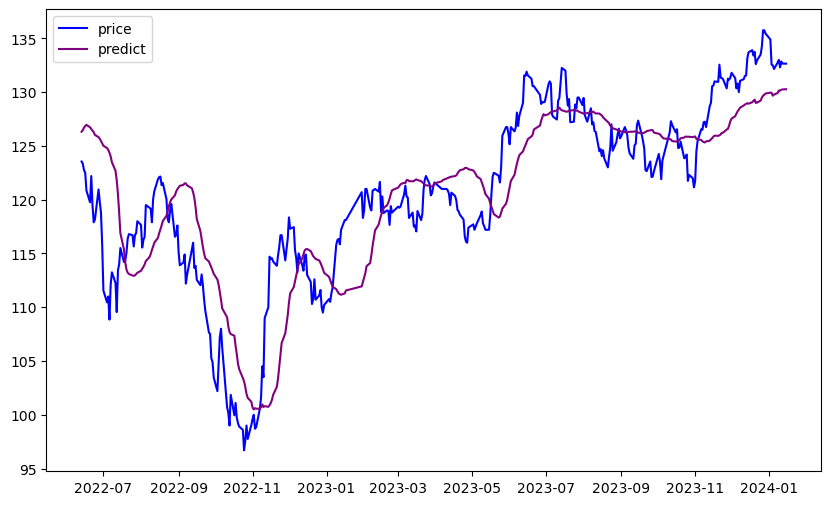

In [146]:
import matplotlib.pyplot as plt

# 繪製測試集與預測結果的對比圖
df_time = df.index[-len(y_test):]  # df_time 是與 y_test 相對應的時間軸
plt.figure(figsize = (10,6))
plt.plot(df_time, y_test, color='blue', label='price')
plt.plot(df_time, pre, color='purple', label='predict')
plt.legend()
plt.show()

## 查看模型是否收斂

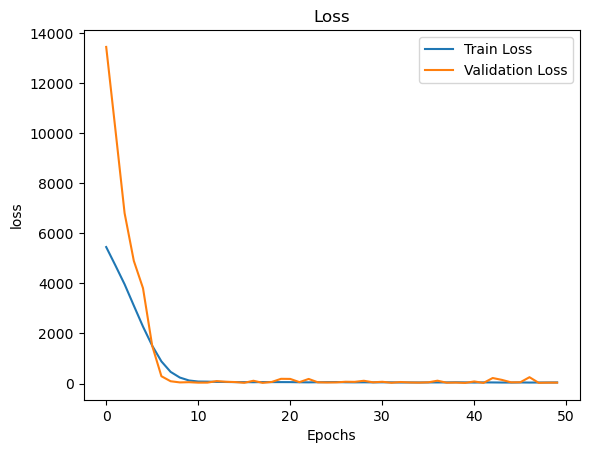

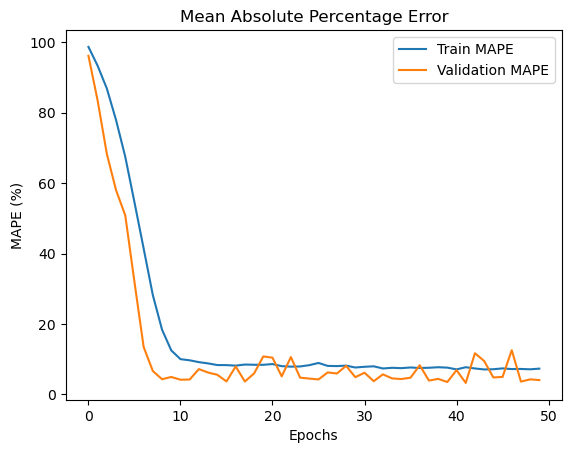

In [153]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.plot(history.history['mape'], label='Train MAPE')  # 訓練 MAPE
plt.plot(history.history['val_mape'], label='Validation MAPE')  # 驗證 MAPE
plt.title("Mean Absolute Percentage Error")
plt.xlabel("Epochs")
plt.ylabel("MAPE (%)")
plt.legend()
plt.show()
